In [13]:
from sklearn.cluster import KMeans
from Utils.my_Spectral import my_Spectral
from ImageClustering import ImageClustering
from Utils.Visualization import *
from Utils.criterion import error, Acc_cls
from Utils.Generate_data import Gnrt_shape, Generate_data_normal
from time import time

In [14]:
# Pre-settings
keyParameters = {'Shape': 'OneCircle',
                 'Sigma of Noise': 2,
                 'Samples Size': 1000}
Parameters = {'Sigma of Image': 1,
              'Power of Image': 7,
              'Power of Block': 3,
              'Proportion of Positive': 0.5,
              'Maximal Iteration': 10,
              'Early Stop Tolerance': 1e-5}
shape = keyParameters['Shape']

## Generate data

In [15]:
''' Generate Data Set '''
sigma_ns = keyParameters['Sigma of Noise']
n = keyParameters['Samples Size']
pw = Parameters['Power of Image']
pw_block = Parameters['Power of Block']
sigma_img = Parameters['Sigma of Image']
p = Parameters['Proportion of Positive']
D1, D2 = np.power(2, pw), np.power(2, pw)
b1, b2 = np.power(2, pw - pw_block), np.power(2, pw - pw_block)
d1, d2 = np.power(2, pw_block), np.power(2, pw_block)

In [16]:
if shape == 'OneCircle':
    signal = Gnrt_shape(D1, D2, shape, radius=11)
elif shape == 'ThreeCircles':
    signal = Gnrt_shape(D1, D2, shape, radius=[8, 6, 4])
else:  # butterfly
    signal = Gnrt_shape(D1, D2, shape)

In [17]:
theta1, theta2, Y, X_TS = Generate_data_normal(signal, n=n, positive_rate=p, sigma_of_image=sigma_img, sigma_of_noise=sigma_ns, seed=0)
D1, D2 = theta1.shape  # Size of Image
p1, p2 = np.power(2, pw - pw_block), np.power(2, pw - pw_block)  # Size of B
d1, d2 = np.power(2, pw_block), np.power(2, pw_block)  # Size of A
shapes = [p1, p2, d1, d2]

### Visualize the signal, mean matrices and samples.

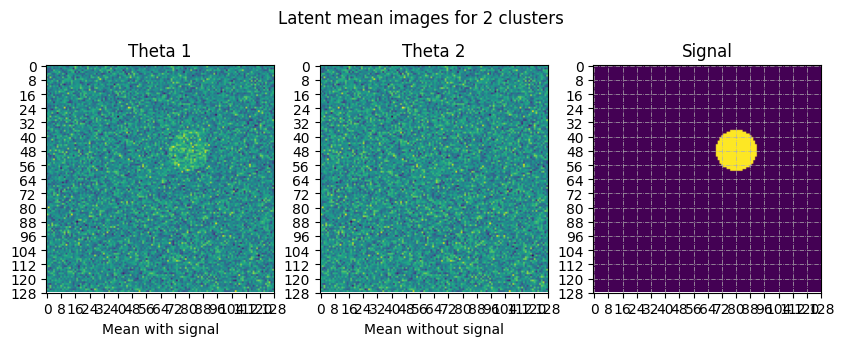

In [18]:
Vis_mean_diff(theta1, theta2, signal, pw_block)  # Show means and signal

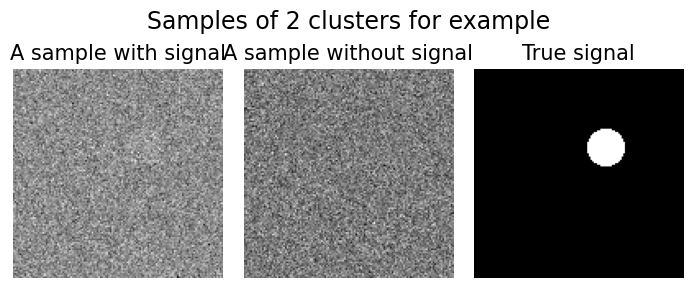

In [19]:
Vis_samples(X_TS[0], X_TS[-1], signal)  # Show samples

## Baselines

In [20]:
''' Baseline '''
X_vec = X_TS.reshape(n, D1 * D2)
CK_labels = KMeans(n_clusters=2, random_state=0).fit_predict(X_vec)
CS_labels = my_Spectral(X_vec, n_clusters=2, random_state=0)
CK_Acc, CS_Acc = Acc_cls(Y, CK_labels), Acc_cls(Y, CS_labels)
print('Baseline | Accuracy | KMeans: {:.4f} Spectral: {:.4f} '.format(CK_Acc, CS_Acc))

Baseline | Accuracy | KMeans: 0.5130 Spectral: 0.7040 


## ICSKPD

In [21]:
''' ICSKPD '''
# Optimization parameters
lam_lst = 0.01 * np.arange(11)
max_itr = Parameters['Maximal Iteration']  # If used
tol = Parameters['Early Stop Tolerance']  # If used
# Model
IC = ImageClustering(n_clusters=2)
stt = time()
CI_labels, C_hat = IC.fit_predict(X_TS, shapes=[(p1, p2), (d1, d2)], lams=lam_lst, max_itr=max_itr, tol=tol, echo=False)
stp = time()
opt_lam = IC.opt_lam
acc = Acc_cls(Y, CI_labels)
FPR, TPR = error(C_hat, signal)
print(f'ICSKPD | Optimal lambda: {opt_lam} | Accuracy: {acc:.3f}, FPR: {FPR:.3f}, TPR: {TPR:.3f}')

ICSKPD | Optimal lambda: 0.02 | Accuracy: 1.000, FPR: 0.022, TPR: 0.998


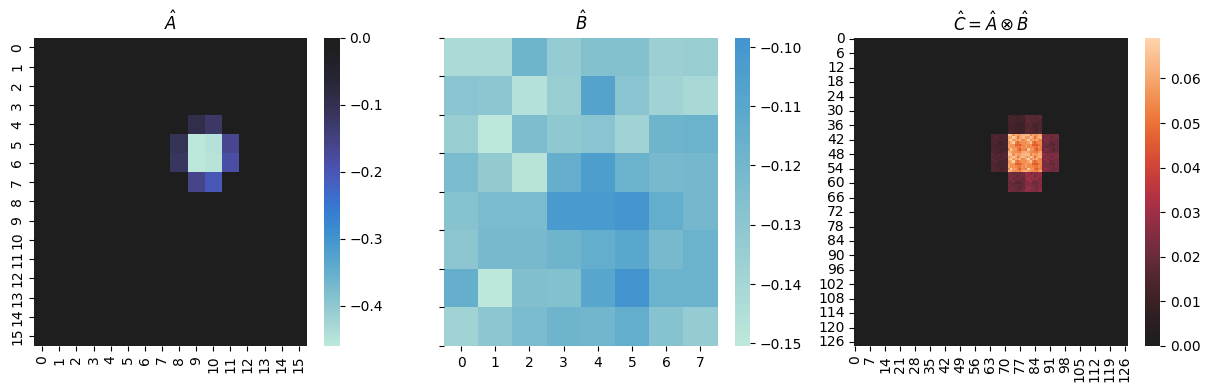

In [22]:
''' Visualization of Detection Result'''
A_hat, B_hat = IC.A_hat, IC.B_hat
Vis_detection(A_hat, B_hat, C_hat, d2)